In [5]:
import os
import sys
import pulp
import numpy as np
from copy import deepcopy, copy
from matplotlib import pyplot as plt

from MOLP import MOLP, Solution
from utils import distribute_line_points, distribute_triangle_points
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [199]:
#----------------------------------------------
# Define the problem
#----------------------------------------------
prob = pulp.LpProblem("DummyBiObjectiveLP",pulp.LpMinimize)

# Variables
x1 = pulp.LpVariable("x1",0,None)
x2 = pulp.LpVariable("x2",0,None)

# Objectives (defined as variables)
f1 = pulp.LpVariable("f1",None,None)
f2 = pulp.LpVariable("f2",None,None)

# Objective function (defined as constraints, to be minimized)
prob += f1 == 10*x1 + 1*x2
prob += f2 == 1*x1 + 4*x2

# Constraints
prob += 4*x1 + 1*x2 >= 6
prob += 1*x1 + 1*x2 >= 4
prob += 1*x1 + 8*x2 >= 2
prob += x1 + x2 <= 10

objectives = [f1,f2]
variables = [x1, x2]

#----------------------------------------------
# Parameters
#----------------------------------------------
num_ref_points = 4

'''
MOLP class

    def __init__(self, prob, objectives, variables):
        self.id = None # Unique identifier
        self.prob = prob
        self.original_prob = deepcopy(prob)
        self.objectives = objectives # List of objective functions (Pulp variables)
        self.variables = variables # List of variables (Pulp variables)
        self.individual_optima = [] # List of individual optima (Solution objects)
'''

class nNBI(MOLP):
    '''
    This class defines the Normal Boundary Intersection (NBI) method for multi-objective linear programs.
    '''
    def __init__(self, prob, objectives, variables):
        super().__init__(prob, objectives, variables)
        self.num_ref_points = None

        self.normalized_ref_points_dict = None
        self.normalized_individual_optima = []
        self.normalized_normal_vector = None
        self.normalized_solutions_dict = None
        self.normalized_objectives = []

        self.original_prob = deepcopy(prob)
        self.original_objectives = deepcopy(objectives)
        self.original_variables = deepcopy(variables)

        self.solutions_dict = {}
        self.ref_points_dict = None

        
    def normalize_objectives_and_individual_optima(self):
        self.individual_optima = []
        self.normalized_individual_optima = []
        # Compute individual optima if not already computed
        self.compute_all_individual_optima()
        # Get ideal and nadir points
        ideal_point = self.ideal_point()
        nadir_point = self.nadir_point()
        # Normalize objectives
        for i in range(self.num_objectives()):
            new_objective = (self.objectives[i] - ideal_point[i]) / (nadir_point[i] - ideal_point[i])
            new_objective.name = self.objectives[i].name+'norm'
            self.normalized_objectives.append(new_objective)
        # Normalize individual optima
        for original_individual_optima in self.individual_optima:
            original_objecives = original_individual_optima.objectives
            normalized_objectives = [(original_objecives[i] - ideal_point[i]) / (nadir_point[i] - ideal_point[i]) for i in range(self.num_objectives())]
            normalized_individual_optima = Solution(normalized_objectives, original_individual_optima.variables)
            self.normalized_individual_optima.append(normalized_individual_optima)  

    def normalized_payoff_matrix(self):
        # Normalize objectives and individual optima if not already computed
        if self.normalized_individual_optima == []:
            self.normalize_objectives_and_individual_optima()
        # Compute payoff table
        payoff_matrix = np.array([[opt.objective_values()[j] for j in range(self.num_objectives())] for opt in self.normalized_individual_optima])
        return payoff_matrix
    
    def normalized_ideal_point(self):
        return np.min(self.normalized_payoff_matrix(), axis=0)
    
    def normalized_nadir_point(self):
        return np.max(self.normalized_payoff_matrix(), axis=0)

    def compute_normalized_ref_points(self, num_points=None):
        if num_points is not None:
            self.num_ref_points = num_points
        # Bi-objective problems
        if self.num_objectives() == 2:
            A = self.normalized_individual_optima[0].objective_values()
            B = self.normalized_individual_optima[1].objective_values()
            normalized_ref_points = distribute_line_points(A, B, self.num_ref_points)
            self.normalized_ref_points_dict = {f'q{i+1}': normalized_ref_points[i] for i in range(normalized_ref_points.shape[0])}
        '''    
        # Tri-objective problems
        elif self.num_objectives() == 3:
            A = self.normalized_individual_optima[0].objective_values()
            B = self.normalized_individual_optima[1].objective_values()
            C = self.normalized_individual_optima[2].objective_values()
            normalized_ref_points = distribute_triangle_points(A, B, C, self.num_ref_points)
            self.normalized_ref_points_dict = {f'q{i+1}': normalized_ref_points[i] for i in range(normalized_ref_points.shape[0])}
        # More than three objectives not implemented
        else:
            raise ValueError("This method is only implemented for bi-objective and tri-objective problems.")
        '''
        # Return dict with reference points
        return self.normalized_ref_points_dict
    
    def compute_normalized_normal_vector(self):
        # Normalize objectives and individual optima if not already computed
        if self.normalized_individual_optima == []:
            self.normalize_objectives_and_individual_optima()
        # Compute normalized reference points if not already computed
        if self.normalized_ref_points_dict is None:
            self.compute_normalized_ref_points()
        # Bi-objective problems
        if self.num_objectives() == 2:
            A = self.normalized_individual_optima[0].objective_values()
            B = self.normalized_individual_optima[1].objective_values()
            direction_vector = B - A
            # Two possible normal vectors
            normal_vector_1 = np.array([-direction_vector[1], direction_vector[0]]) 
            normal_vector_2 = -normal_vector_1
            # Determine which normal vector points to the half-space where the ideal point is located
            if np.dot(normal_vector_1, self.normalized_ideal_point() - A) > 0:
                self.normalized_normal_vector = normal_vector_1 / np.linalg.norm(normal_vector_1)
            else:
                self.normalized_normal_vector = normal_vector_2 / np.linalg.norm(normal_vector_1)
        '''        
        # Tri-objective problems
        elif self.num_objectives() == 3:
            A = self.individual_optima[0].objective_values()
            B = self.individual_optima[1].objective_values()
            C = self.individual_optima[2].objective_values()
            direction_vector_1 = B - A
            direction_vector_2 = C - A
            # Two possible normal vectors
            normal_vector_1 = np.cross(direction_vector_1, direction_vector_2)
            normal_vector_2 = -normal_vector_1
            # Determine which normal vector points to the half-space where the ideal point is located
            if np.dot(normal_vector_1, self.ideal_point() - A) > 0:
                self.normal_vector = normal_vector_1 / np.linalg.norm(normal_vector_1)
            else:
                self.normal_vector = normal_vector_2 / np.linalg.norm(normal_vector_1)
        # More than three objectives not implemented
        else:
            raise ValueError("This method is only implemented for bi-objective and tri-objective problems.")
        '''
        return self.normalized_normal_vector

    def solve_normalized_NBI_subproblem(self, normalized_ref_point):
        sub_problem = deepcopy(self.prob)
        t = pulp.LpVariable("t", 0, None)
        sub_problem.setObjective(t)
        sub_problem.sense = pulp.LpMaximize
        for i in range(self.num_objectives()):
            sub_problem += normalized_ref_point[i] + t * self.normalized_normal_vector[i] == self.normalized_objectives[i]
        sub_problem.solve(pulp.PULP_CBC_CMD(msg=0))
        new_variables = []
        # Update variables but not the objective functions (already updated)
        for v in sub_problem.variables():
            if v.name in [var.name for var in self.variables]:
                new_variables.append(v)
        solution = Solution(self.normalized_objectives, new_variables)
        sub_problem = None
        return solution

    def normalized_NBI_algorithm(self, num_points):
        self.num_ref_points = num_points
        # Compute reference points and normal vector
        self.compute_normalized_ref_points()
        self.compute_normalized_normal_vector()
        self.normalized_solutions_dict = {}
        # Solve NBI subproblem for each reference point
        for ref_id, ref_point in self.normalized_ref_points_dict.items():
            solution = self.solve_normalized_NBI_subproblem(ref_point)
            # Store solution in dictionary {ref_point_id: Solution object}
            self.normalized_solutions_dict[ref_id] = solution
            #print('Inside NBI algorithm:', ref_id, ' ', 'ref: ', ref_point, 'sol:', solution.objective_values(), 'var:', solution.variable_values())
        print("NBI algorithm completed.")
        return self.normalized_solutions_dict

   
    def normalize_objectives_and_individual_optima(self):
        self.individual_optima = []
        self.normalized_individual_optima = []
        # Compute individual optima if not already computed
        self.compute_all_individual_optima()
        # Get ideal and nadir points
        ideal_point = self.ideal_point()
        nadir_point = self.nadir_point()
        # Normalize individual optima and objectives
        for original_individual_optima in self.individual_optima:
            # Normalize objectives
            original_objecives = original_individual_optima.objectives
            normalized_obbjectives = []
            for i in range(self.num_objectives()):
                new_objective = (original_objecives[i] - ideal_point[i]) / (nadir_point[i] - ideal_point[i])
                new_objective.name = original_objecives[i].name+'norm'
                normalized_obbjectives.append(new_objective)
            self.normalized_objectives = normalized_obbjectives
            # Normalize individual optima
            normalized_individual_optima = Solution(self.normalized_objectives, original_individual_optima.variables)
            self.normalized_individual_optima.append(normalized_individual_optima)

    def denormalize_solutions(self):
        # Denormalize solutions and store in dictionary {ref_point_id: Solution object}
        denormalized_solutions_dict = {}
        for ref_id, normalized_solution in self.normalized_solutions_dict.items():
            # Denormalize objectives
            normalized_objectives = normalized_solution.objectives
            denormalized_objectives = []
            # Denormalize objectives and return to original names
            for i in range(self.num_objectives()):
                denormalized_objective = normalized_objectives[i] * (self.nadir_point()[i] - self.ideal_point()[i]) + self.ideal_point()[i]
                denormalized_objective.name = normalized_objectives[i].name.replace('norm', '')             
                denormalized_objectives.append(denormalized_objective)
            self.objectives = denormalized_objectives
            # Denormalize solution
            denormalized_solution = Solution(denormalized_objectives, normalized_solution.variables)
            denormalized_solutions_dict[ref_id] = denormalized_solution
        self.solutions_dict = denormalized_solutions_dict
        # Denormalize reference points
        self.denormalize_ref_points()

        return self.solutions_dict
    
    def denormalize_ref_points(self):
        self.ref_points_dict = {}
        for ref_id, normalized_ref_point in self.normalized_ref_points_dict.items():
            denormalized_ref_point = []
            for i in range(self.num_objectives()):
                denormalized_ref_point.append(normalized_ref_point[i] * (self.nadir_point()[i] - self.ideal_point()[i]) + self.ideal_point()[i])
            self.ref_points_dict[ref_id] = np.array(denormalized_ref_point)

    
    def ref_points_values(self):
            if self.ref_points_dict is None:
                raise ValueError("No reference points have been computed yet.")
            return np.array([ref_point for ref_point in self.ref_points_dict.values()])
        
    def solutions_values(self):
        if self.solutions_dict is None:
            raise ValueError("No solutions have been computed yet.")
        return np.array([sol.objective_values() for sol in self.solutions_dict.values()])

    def solutions_ref_to_values(self):
        if self.solutions_dict is None:
            raise ValueError("No solutions have been computed yet.")
        return {ref_id: sol.objective_values() for ref_id, sol in self.solutions_dict.items()}

    def solutions_variable_values(self):
        if self.solutions_dict is None:
            raise ValueError("No solutions have been computed yet.")
        return np.array([sol.variable_values() for sol in self.solutions_dict.values()])

def plot_NBI_2D(nbi, normalize_scale = True):
    objective_values = nbi.solutions_ref_to_values() # Dict with refpoint_id: [objective_values_of_solution]
    reference_points = nbi.ref_points_dict # Dict with refpoint_id: [objective_values_of_refpoint]
    # Plot the Pareto front
    plt.figure(figsize=(6, 6))
    # Plot solution points
    for ref_id, obj_values in objective_values.items():
        plt.scatter(obj_values[0], obj_values[1], color='red', s=40, zorder=5)
    # Line connecting reference points
    for i in range(nbi.num_ref_points - 1):
        plt.plot([reference_points[f'q{i+1}'][0], reference_points[f'q{i+2}'][0]], 
                 [reference_points[f'q{i+1}'][1], reference_points[f'q{i+2}'][1]], color='blue', zorder=3)
    # Plot reference points
    for ref_id, ref_values in reference_points.items():
        plt.scatter(ref_values[0], ref_values[1], color='blue', s=20, zorder=6)
    # Plot the arrows connecting reference points to solutions
    for ref_id, ref_values in reference_points.items():
        obj_values = objective_values[ref_id]
        plt.arrow(ref_values[0], ref_values[1], obj_values[0] - ref_values[0], obj_values[1] - ref_values[1], 
                    head_width=0.01, head_length=0.01, fc='gray', ec='gray', zorder=4)
    
    plt.xlabel(nbi.objectives[0].name)
    plt.ylabel(nbi.objectives[1].name)
    plt.title('NBI method, NBI method with ' + str(nbi.num_ref_points) + ' reference points')
    plt.grid(True)
    if not normalize_scale:
        plt.gca().set_aspect('equal', adjustable='box')  # Ensure the same scale for x and y axes
    plt.show()

Individual optima and objectives before normalization:
[array([ 6., 24.]), array([40.,  4.])]
[f1, f2]
[6. 4.]
[40. 24.]
Individual optima and objectives after normalization:
[array([-2.77555756e-17,  1.00000000e+00]), array([1., 0.])]
[0.029411764705882353*f1 + -0.17647058823529413, 0.05*f2 + -0.2]
[f1, f2]
[{'f1norm': np.float64(-2.7755575615628914e-17), 'f2norm': np.float64(1.0000000000000002)}, {'f1norm': np.float64(1.0), 'f2norm': np.float64(0.0)}]
Compute normalized ref points:
{'q1': array([-2.77555756e-17,  1.00000000e+00]), 'q2': array([0.33333333, 0.66666667]), 'q3': array([0.66666667, 0.33333333]), 'q4': array([1., 0.])}
Compute normalized normal vector:
[-0.70710678 -0.70710678]
Compute normalized NBI algorithm:
NBI algorithm completed.
{'q1': <MOLP.Solution object at 0x000002DCC71CF470>, 'q2': <MOLP.Solution object at 0x000002DCC71CED80>, 'q3': <MOLP.Solution object at 0x000002DCC71E8890>, 'q4': <MOLP.Solution object at 0x000002DCC6238DD0>}
{'f1norm': np.float64(-2.7755575

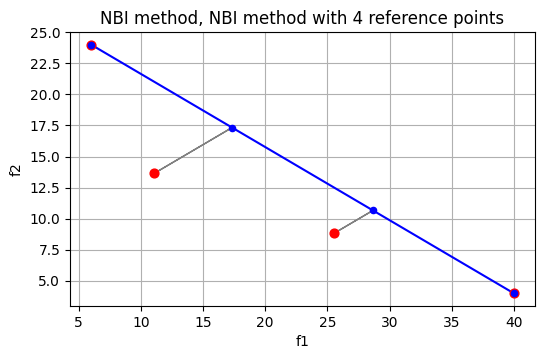

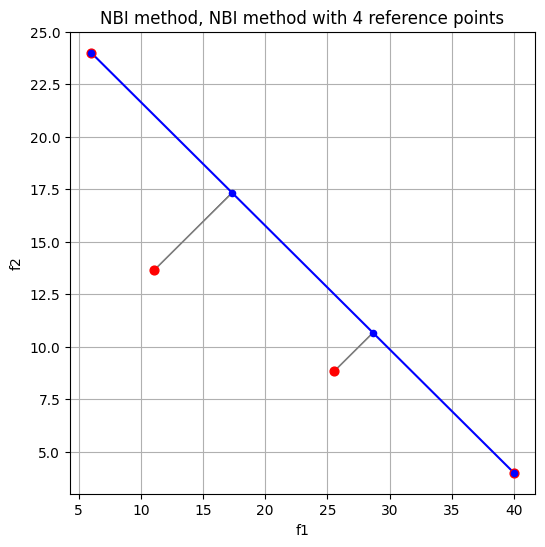

In [200]:
# Create the NBI object (inherits from MOLP and adds the NBI algorithm)
nnbi = nNBI(prob, objectives, variables)

nnbi.compute_all_individual_optima()

print("Individual optima and objectives before normalization:")
print([ind_opt_sol.objective_values() for ind_opt_sol in nnbi.individual_optima])
print(nnbi.objectives)
print(nnbi.ideal_point())
print(nnbi.nadir_point())


nnbi.normalize_objectives_and_individual_optima()

print("Individual optima and objectives after normalization:")
print([ind_opt_sol.objective_values() for ind_opt_sol in nnbi.normalized_individual_optima])
print(nnbi.normalized_objectives)
print(nnbi.original_objectives)
print([ind_opt_sol.objective_dict() for ind_opt_sol in nnbi.normalized_individual_optima])

print("Compute normalized ref points:")
print(nnbi.compute_normalized_ref_points(num_points=num_ref_points))

print("Compute normalized normal vector:")
print(nnbi.compute_normalized_normal_vector())

print("Compute normalized NBI algorithm:")
nnbi.normalized_NBI_algorithm(num_ref_points)
print(nnbi.normalized_solutions_dict)
for ref, solution in nnbi.normalized_solutions_dict.items():
    print(solution.objective_dict())

print("Denormalize solutions:")
nnbi.denormalize_solutions()
print(nnbi.solutions_dict)
for ref, solution in nnbi.solutions_dict.items():
    print(solution.objective_dict())

plot_NBI_2D(nnbi, normalize_scale=False)
plot_NBI_2D(nnbi, normalize_scale=True)